In [157]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data 

In [158]:
df_viirs= pd.read_csv(r"E:\Azadeh\Data Science-Lighthouse\Datasets\ForestFire\viirs-snpp_2021_Canada.csv")

In [159]:
# df_viirs.head()

# Data preproccessing 

In [160]:
# Convet date column() to datetime format and get year, month, day 

df_viirs['acq_date'] = pd.to_datetime(df_viirs['acq_date'], format = '%Y-%m-%dT', errors = 'coerce')
df_viirs['year'] = df_viirs['acq_date'].dt.year
df_viirs['month'] = df_viirs['acq_date'].dt.month
df_viirs['day'] = df_viirs['acq_date'].dt.day

In [161]:
df_viirs.year.value_counts()

2021    450281
Name: year, dtype: int64

In [162]:
df_viirs.columns

Index(['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_ti5', 'frp', 'daynight', 'type', 'year', 'month', 'day'],
      dtype='object')

In [163]:
df_viz.latitude.value_counts()

50.313446    7
50.314133    6
52.052299    6
53.210983    6
52.060452    6
            ..
56.256706    1
56.877625    1
56.297642    1
56.262840    1
53.539963    1
Name: latitude, Length: 398194, dtype: int64

In [165]:
# check the columns with one value 
# the out put shows we have one value for satellite so we can drop it
df_viirs.satellite.value_counts()

N    450281
Name: satellite, dtype: int64

In [166]:
# the out put indicate that there is only one value for version so we can drop it as well 
df_viirs.version.value_counts()

1    450281
Name: version, dtype: int64

In [167]:
df_viirs.instrument.value_counts()

VIIRS    450281
Name: instrument, dtype: int64

In [168]:
# I dropped satellite, instrument and version because they only have one value so they are not valuable for our model 
# Also we can drop acq_date as we convert it to datetime features
# Because we are predicting the intensity of fire for future the year wouldn't be important for our model so we can drop it 
df_viirs = df_viirs.drop(['acq_date','satellite','instrument','version','year'],axis=1)

In [169]:
# Checking the values of target variable
df_viirs.confidence.value_counts()

n    408734
h     27499
l     14048
Name: confidence, dtype: int64

### seprate indepandant variables as X and the target variable as y


In [170]:
# I dropped satellite and instrument because they only has one value so they are not important for our model 
X = df_viirs.drop(['confidence'],axis=1)
y = df_viirs['confidence']
print(X.shape)
print(y.shape)

(450281, 12)
(450281,)


In [171]:
y.value_counts()

n    408734
h     27499
l     14048
Name: confidence, dtype: int64

In [172]:
#X.head()

## Convert categorical variable to nummeric
  The only categorical column is daynigh

In [173]:
#daynight = {"D": 1, "N": 0}
#X['daynight']= X['daynight'].map(daynight)
X = pd.get_dummies(X, columns=['daynight'])
#X.head()

# Applying SMOTE to handle imbalanced data 

In [20]:
# we need to split the data before SMOTE
from sklearn.model_selection import train_test_split
  
# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)



In [174]:
#X_train.shape
#X_train.head()

In [22]:
y_train.shape

(315196,)

In [23]:
X_test.shape

(135085, 13)

In [24]:
# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

print(X_smote.shape)
print(y_smote.shape)

(858663, 13)
(858663,)


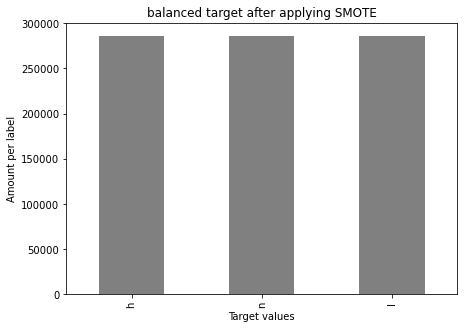

In [148]:
# plot the balanced data 
fig= plt.figure(figsize=(7,5)) 
y_smote.value_counts().plot(kind='bar', color={"gray", "gray",'gray'})
plt.title('balanced target after applying SMOTE')
plt.xlabel('Target values')
plt.ylabel('Amount per label')
plt.show()
#fig.savefig('Balanced_SMOTE.jpg', bbox_inches='tight', dpi=150)

In [175]:
#X_smote.head()

In [176]:
#X_smote.info()

# Feature Engineering

In [178]:
# checking the correlation matrix to find correlated features

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.heatmap(X_smote.corr(), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Plot Only the Lower Half of a Correlation Matrix 

In [179]:
import numpy as np

mask = np.triu(np.ones_like(X_smote.corr(), dtype=bool))
plt.figure(figsize=(10, 10))

sns.heatmap(X_smote.corr(), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [180]:
# Removing Features With Small Variance
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(X_smote)

# get the columns to see which ones are removed
selected_columns = X_smote.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
df_transformed = pd.DataFrame(df_transformed, columns = selected_columns)
#df_transformed

### As you can see Scan and Track variables that have a low variance are removed  

In [31]:
#removing the features with less correlation based on correlation matrix(<.5)

df_corr = df_transformed.corr().abs()

# step 2
indices = np.where(df_corr > 0.5) 
indices = [(df_corr.index[x], df_corr.columns[y]) 
             for x, y in zip(*indices) if x != y and x < y]

# step 3
for idx in indices: #each pair
    try:
        df_transformed.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [32]:
print(indices)

[('acq_time', 'daynight_D'), ('acq_time', 'daynight_N'), ('bright_ti5', 'frp'), ('daynight_D', 'daynight_N')]


In [181]:
#df_transformed.head()

In [34]:
# printing the features we will use for prediction 
df_transformed.columns

Index(['latitude', 'longitude', 'bright_ti4', 'acq_time', 'bright_ti5', 'type',
       'month', 'day'],
      dtype='object')

In [35]:
# Set the Train ans Test set based on the selected features
columns=['latitude', 'longitude', 'bright_ti4', 'acq_time', 'bright_ti5', 'type',
            'month', 'day']
X_smote= X_smote[columns]
X_test= X_test[columns] 

# Building the model

## Naive bayes classifier


In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB().fit(X_smote, y_smote)
gnb_predictions = gnb.predict(X_test)

In [37]:
train_accuracy = gnb.score(X_smote, y_smote)
test_accuracy = gnb.score(X_test, y_test)
print ('Naive bayes accuracy: ')
print('train set accuracy: ', train_accuracy)
print('test set accuracy: ', test_accuracy)
print()
print(classification_report(y_test, gnb_predictions))



Naive bayes accuracy: 
train set accuracy:  0.7410567358789187
test set accuracy:  0.7150756930821335

              precision    recall  f1-score   support

           h       0.82      1.00      0.90      8305
           l       0.05      0.49      0.10      4267
           n       1.00      0.70      0.82    122513

    accuracy                           0.72    135085
   macro avg       0.62      0.73      0.61    135085
weighted avg       0.96      0.72      0.81    135085



In [38]:
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, gnb_predictions)*100)

Gaussian Naive Bayes model accuracy(in %): 71.50756930821335


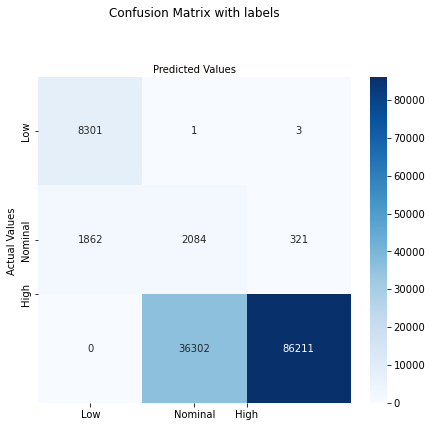

In [58]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix

cf_matrix_NB = confusion_matrix(y_test, gnb_predictions)
class_names=['Low','Nominal','High']
fig, ax = plt.subplots(figsize=(7, 6))

ax = sns.heatmap(cf_matrix_NB, annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(Col_name)
#ax.yaxis.set_ticklabels(Col_name)
tick_marks = [0.5, 1.5,2]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

## Display the visualization of the Confusion Matrix.
plt.show()

In [59]:
fig.savefig('NaiveBayes_Confusion_matrix.jpg', bbox_inches='tight', dpi=300)

In [182]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': gnb_predictions})
#df

# Random Forest Classifier

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# tunning hyper parameters with gridsearch

max_depth=[ 10,50,100]
n_estimators = [64, 128, 256]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

# Build the grid search
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(X_smote, y_smote)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)
results_df

Best: [0.94143803 0.94338757 0.94165813 0.98788349 0.9881234  0.98805818
 0.98792192 0.98800344 0.98805352], using {'max_depth': 50, 'n_estimators': 128}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,66.234908,5.386583,1.313431,0.109139,10,64,"{'max_depth': 10, 'n_estimators': 64}",0.927469,0.943366,0.947215,0.941164,0.947977,0.941438,0.007417,9
1,123.676717,3.221596,2.437193,0.156163,10,128,"{'max_depth': 10, 'n_estimators': 128}",0.935994,0.948624,0.941164,0.946824,0.944332,0.943388,0.004466,7
2,226.997688,2.159923,4.651444,0.308394,10,256,"{'max_depth': 10, 'n_estimators': 256}",0.944722,0.943546,0.944024,0.932342,0.943656,0.941658,0.004676,8
3,77.962321,0.673183,2.154145,0.045028,50,64,"{'max_depth': 50, 'n_estimators': 64}",0.986368,0.988872,0.988016,0.987987,0.988173,0.987883,0.000823,6
4,231.324641,142.766970,5.154957,1.771232,50,128,"{'max_depth': 50, 'n_estimators': 128}",0.986654,0.988948,0.988057,0.988389,0.988569,0.988123,0.000789,1
5,317.836405,4.867959,11.006320,0.369415,50,256,"{'max_depth': 50, 'n_estimators': 256}",0.986531,0.988890,0.988174,0.988237,0.988459,0.988058,0.000804,2
6,108.982398,53.819858,2.596664,0.461681,100,64,"{'max_depth': 100, 'n_estimators': 64}",0.986508,0.988756,0.988010,0.988121,0.988214,0.987922,0.000752,5
7,165.467549,6.227326,4.371369,0.236673,100,128,"{'max_depth': 100, 'n_estimators': 128}",0.986491,0.988762,0.988045,0.988255,0.988465,0.988003,0.000793,4
8,501.347804,370.274183,11.250421,0.463648,100,256,"{'max_depth': 100, 'n_estimators': 256}",0.986584,0.988750,0.988109,0.988389,0.988435,0.988054,0.000762,3


In [44]:
grid_results.best_estimator_

RandomForestClassifier(max_depth=50, n_estimators=128)

([<matplotlib.axis.YTick at 0x18c15528550>,
 [Text(0, 0.5, 'Low'), Text(0, 1.5, 'Nominal'), Text(0, 2.0, 'High')])

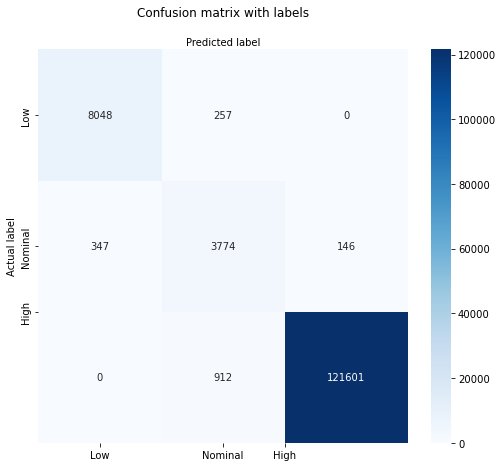

In [45]:
dfrst = RandomForestClassifier(n_estimators=128, max_depth=50)
dfrst.fit(X_smote, y_smote)
#best_clf = grid_results.best_estimator_
y_pred_rf = dfrst.predict(X_test)

# Create a confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

class_names= ['Low','Nominal','High']

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix_rf), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with labels\n')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5,2]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [46]:
#fig.savefig('RandomForest_Confusion_matrix.jpg', bbox_inches='tight', dpi=300)

In [68]:
#Checking the accuracy
train_accuracy = round(grid_results.score(X_smote, y_smote)*100,2)
test_accuracy = round(grid_results.score(X_test, y_test)*100,2)
print ('Random Forest accuracy:')
print()
print('Accuracy on train set (max_depth: 50, n_estimators: 256): ', train_accuracy,'%')
print('Accuracy on test set (max_depth: 50, n_estimators: 256): ', test_accuracy,'%')
print()
print(classification_report(y_test, y_pred_rf))



Random Forest accuracy:

Accuracy on train set (max_depth: 50, n_estimators: 256):  100.0 %
Accuracy on test set (max_depth: 50, n_estimators: 256):  98.76 %

              precision    recall  f1-score   support

           h       0.96      0.97      0.96      8305
           l       0.76      0.88      0.82      4267
           n       1.00      0.99      1.00    122513

    accuracy                           0.99    135085
   macro avg       0.91      0.95      0.93    135085
weighted avg       0.99      0.99      0.99    135085



In [71]:
# Save random forest Model 
import pickle

pickle.dump( dfrst, open( "RandomForest_model", "wb" ) )


# Gradient Boosting algorithm

In [183]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_booster = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=100)
#gradient_booster.get_params()

In [70]:
gradient_booster.fit(X_smote, y_smote)
y_pred_gb= gradient_booster.predict(X_test)
print(classification_report(y_test,y_pred_gb))

              precision    recall  f1-score   support

           h       0.96      0.97      0.96      8305
           l       0.75      0.91      0.82      4267
           n       1.00      0.99      1.00    122513

    accuracy                           0.99    135085
   macro avg       0.91      0.96      0.93    135085
weighted avg       0.99      0.99      0.99    135085



In [72]:
print(gradient_booster.score(X_test, y_test)) 

0.9877188436910094


# XGboost Algorithm 

In [73]:
# because our lables are not numeric we need to convert it to numeric for XGboost
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_smote)
label_encoded_y = label_encoder.transform(y_smote)

In [74]:
test_encoder= LabelEncoder()
test_encoder= test_encoder.fit(y_test)
y_test_encoded= test_encoder.transform(y_test)


In [76]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective ='objective=multi:softmax', max_depth=10, n_estimators=100, learning_rate=0.1,use_label_encoder=False,eval_metric='logloss') 
xgb_model.fit(X_smote, label_encoded_y)

y_pred_xgb= xgb_model.predict(X_test)

prob_train = xgb_model.predict_proba(X_smote)
prob_test = xgb_model.predict_proba(X_test)

In [184]:
#xgb.plot_importance(xgb_model)
print()
print()
print(classification_report(y_test_encoded, y_pred_xgb))



              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8305
           1       0.74      0.92      0.82      4267
           2       1.00      0.99      1.00    122513

    accuracy                           0.99    135085
   macro avg       0.90      0.96      0.93    135085
weighted avg       0.99      0.99      0.99    135085



In [79]:
#print('Probability of ')
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_encoded, y_pred_xgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.75%


In [187]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)

class_names= ['Low','Nominal','High']

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix with labels\n')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5,2]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

In [150]:
#fig.savefig('XGBoost_Confusion_matrix.jpg', bbox_inches='tight', dpi=300)